# Test custom version of conjugate gradient algorithm

In [1]:
from autograd import numpy as np, grad
from utils.imgUtils import getTestImage, rescale
from functions import getImageData
import matplotlib.pyplot as plt
import optimize 
from tqdm import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def getPositions(obj_npix, probe_npix, num_steps):
    step_size = (obj_npix - probe_npix) // num_steps 
    positions = []
    for r in range(num_steps):
        for c in range(num_steps):
            positions.append([r * step_size, c * step_size])
    return np.array(positions)

In [4]:
def getDiffractionIntensities(obj, probe, positions, obj_shape):
    obj = np.reshape(obj, obj_shape)
    diffraction_intensity = []#np.zeros((positions.shape[0], *probe.shape), dtype='float32')
    for indx, (r, c) in enumerate(positions):
        r2 = r + probe.shape[0]
        c2 = c + probe.shape[0]
        obj_slice = obj[r:r2, c:c2]
        exit_wave = probe * obj_slice
        farfield_wave = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(exit_wave), norm='ortho'))
        diffraction_intensity.append(np.abs(farfield_wave))
    return np.array(diffraction_intensity)

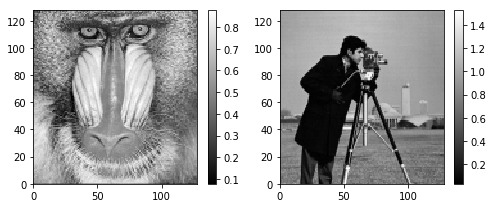

In [5]:
obj_npix = 128
obj = rescale(getTestImage(), 4)
plt.figure(figsize=[7,3])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(obj), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(obj), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()

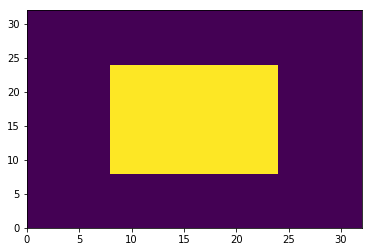

In [6]:
probe_npix = 32
probe = np.zeros((32,32)).astype('complex64')
probe[8:24, 8:24] = 1
probe = probe / np.sqrt(np.sum(np.abs(probe)**2)) * np.sqrt(1e6)
plt.pcolormesh(np.abs(probe))
plt.show()

In [7]:
positions = getPositions(obj_npix, probe_npix, 20)

In [8]:
diffraction_intensities = getDiffractionIntensities(obj.flatten(), probe, positions, obj.shape)

In [9]:
loss = lambda obj_guess_flat: np.mean((getDiffractionIntensities(obj_guess_flat, probe, positions, obj.shape)
                                  - diffraction_intensities)**2)

In [10]:
loss_grad = lambda obj_guess_flat: np.conjugate(grad(loss)(obj_guess_flat)) 

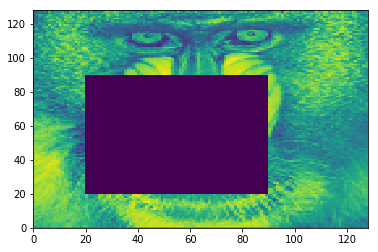

In [11]:
obj_guess = obj.copy()
obj_guess[20:90, 20:90] = 0
obj_guess_flat = obj_guess.flatten()
fig = plt.figure()
plt.pcolormesh(np.abs(obj_guess))
fig.canvas.draw()

In [12]:
loss(obj_guess_flat)

234.50249588228067

In [13]:
xopt = optimize.fmin_cg(f=loss, x0=obj_guess_flat, fprime=loss_grad, maxiter=50)

         Current function value: 0.007744
         Iterations: 17
         Function evaluations: 71
         Gradient evaluations: 61


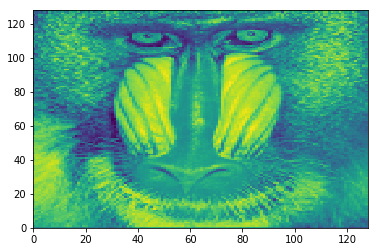

In [14]:
plt.pcolormesh(np.abs(xopt).reshape(obj.shape))
plt.show()

In [111]:
class AdamOptimizer(object):
    def __init__(self, loss_function, init_weights, step_size=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """beta1 and beta2 are the coefficients for the first and second moment respectively."""
        self.lossfn = loss_function
        self.weights = init_weights.copy()
        self.gradfn = lambda obj_guess: np.conjugate(grad(self.lossfn)(obj_guess)) 
        self.step_size = step_size
        
        assert( 0 <= beta1 < 1), "Beta1 should be within [0,1)"
        assert( 0 <= beta2 < 1), "Beta2 should be within [0, 1)"
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        
        self.first_moment = 0
        self.second_moment = 0
        self.learning_rate_current = 0
        
        self.nsteps = 0
        self.losses = [self.lossfn(init_weights)]
        self.weight_guesses = np.array([self.weights.copy()])
        
    def minimize(self, num_steps):
        self.nsteps += num_steps
        for i in range(num_steps):
            gradvals = self.gradfn(self.weights)
            lossval = self.lossfn(self.weights)
            self.losses = np.append(self.losses, lossval)

            self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * gradvals
            self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * np.abs(gradvals)**2
        
            self.step_size_current = (self.step_size * np.sqrt(1 - self.beta2 ** self.nsteps) / 
                                          (1 - self.beta1 ** self.nsteps))
            self.weights = self.weights - (self.step_size_current * self.first_moment / 
                                           (np.sqrt(self.second_moment) + self.epsilon))
            mask = np.abs(self.weights) > 1
            self.weights[mask] = self.weights[mask] / (np.abs(self.weights[mask]) + 1e-8)
            
            self.weight_guesses = np.append(self.weight_guesses, self.weights.copy())
        return lossval

In [112]:
opt = AdamOptimizer(loss, obj_guess, step_size=1e0)

In [113]:
for i in range(5):
    print(opt.minimize(10))

29.194221028029133
10.325043702965754
3.3764806741385747
1.278188854290268
0.4734998710314805


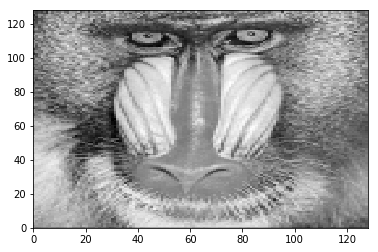

In [27]:
plt.pcolormesh(np.abs(opt.weights), cmap='gray')
plt.show()